In [1]:
import chemfit
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
# We configure chemfit to use Grid7 models and set the spectrograph configuration to PFS
chemfit.initialize('Grid7', 'PFS')

# Specify path to Grid7 models (the directory containing "grid7" and "gridie")
# Alternatively, this definition may be moved to settings/local/Grid7.py (untracked)
chemfit.settings['griddir'] = '<path_to_Grid7>'

Generate a synthetic observation at given stellar parameters:

In [3]:
# Stellar parameters
params = {'teff': 4000, 'logg': 1.5, 'zscale': -1.0, 'alpha': 0.3}

# Interpolate the model grid
interpolator = chemfit.ModelGridInterpolator(resample = False)
model_wl, model_flux = interpolator(params)

# Simulate observation with PFS in blue and red arms with medium resolution
wl, flux = chemfit.simulate_observation(model_wl, model_flux, detector_wl = ['blue', 'red_mr'], combine = False)

# Generate noise with SNR=15
SNR = 15
ivar = {}
for arm in flux:
    sigma = flux[arm] / SNR
    ivar[arm] = sigma ** -2.0
    flux[arm] = np.random.normal(flux[arm], sigma)

/home/roman/PFS/chemfit/chemfit.py:58: UserWarning: In spectrograph arm blue the model does not cover the full wavelength range of the detector. Affected bins were set to np.nan
  warnings.warn(message)


Run the model fit using gradient descent:

In [4]:
# Initial guesses
initial = {'teff': 5000, 'logg': 2.0, 'zscale': 0.0, 'alpha': 0.0}

# Run the fitter
fit_grad = chemfit.chemfit(wl, flux, ivar, initial, method = 'gradient_descent')

print('Best-fit parameters:', fit_grad['fit'])
print('Errors:', fit_grad['errors'])

Best-fit parameters: {'teff': 4006.468038344204, 'logg': 1.3978929879338788, 'zscale': -0.9972194696100505, 'alpha': 0.3155368571059849}
Errors: {'zscale': 0.05493203649308534, 'alpha': 0.03701709477194751, 'teff': 31.27019745212682, 'logg': 0.10955559947956847}


Run the model fit using MCMC:

In [5]:
fit_mcmc = chemfit.chemfit(wl, flux, ivar, initial, method = 'mcmc')

print('Best-fit parameters:', fit_mcmc['fit'])
print('Errors:', fit_mcmc['errors'])

100%|███████████████████████████████████████| 5000/5000 [04:45<00:00, 17.51it/s]


Best-fit parameters: {'teff': 4001.567333377044, 'logg': 1.3884470033840168, 'zscale': -1.0010785162372915, 'alpha': 0.3152822363069933}
Errors: {'zscale': 0.047020652851071924, 'alpha': 0.03753616347892959, 'teff': 32.69350952546323, 'logg': 0.1069249474537563}


Generate the corner of the MCMC posteriors:

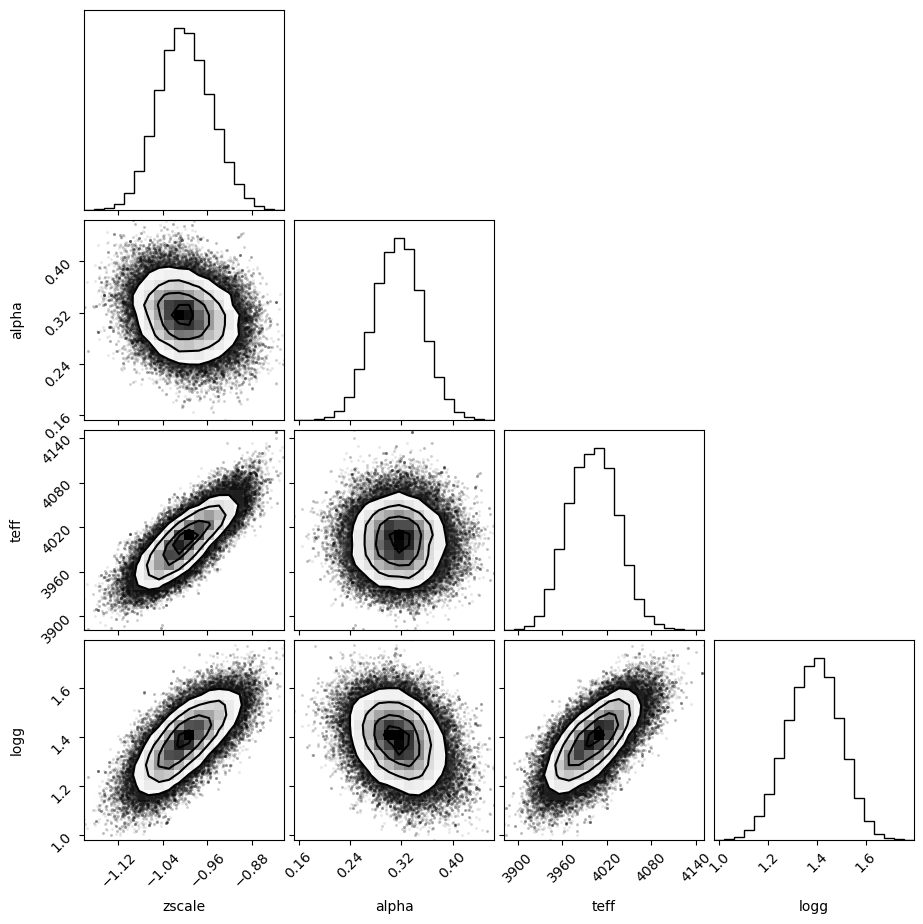

In [6]:
import corner

chain = fit_mcmc['extra']['chain'][500:,:,:]
flatchain = chain[:,:,:].reshape(chain.shape[0] * chain.shape[1], -1)
fig = corner.corner(flatchain, labels = chemfit.settings['fit_dof']);

Plot the best-fit spectrum:

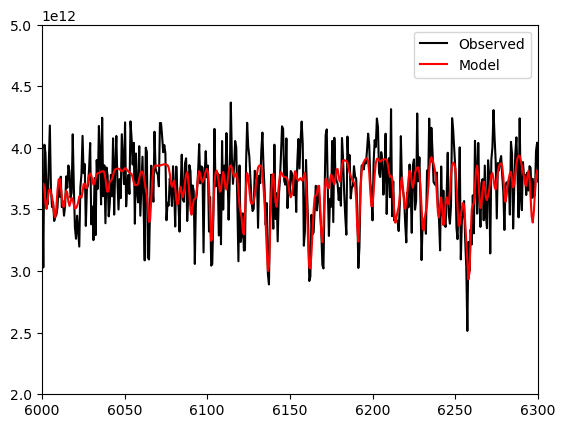

In [7]:
plt.plot(fit_mcmc['extra']['observed']['wl'], fit_mcmc['extra']['observed']['flux'], 'k-', label = 'Observed')
plt.plot(fit_mcmc['extra']['model']['wl'], fit_mcmc['extra']['model']['cont'] * fit_mcmc['extra']['model']['flux'], 'r-', label = 'Model')

plt.xlim(6000, 6300)
plt.ylim(2e12, 5e12)
plt.legend()